In [54]:
import math
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from collections import Counter

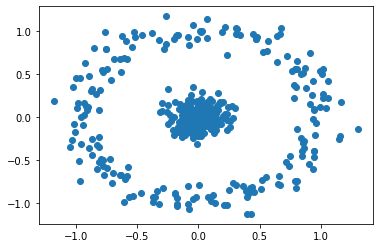

In [399]:
# %% 사이킷런 링 데이터 (과녁형)
df, y = datasets.make_circles(n_samples=400, factor=.1, noise=.1, random_state=42)
plt.scatter(df[:, 0], df[:, 1])

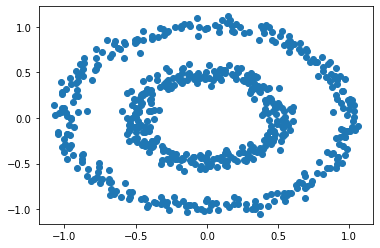

In [471]:
# %% 사이킷런 링 데이터 (고리 2개)
df, y = datasets.make_circles(n_samples=600, factor=.5, noise=.05, random_state=42)
plt.scatter(df[:, 0], df[:, 1])

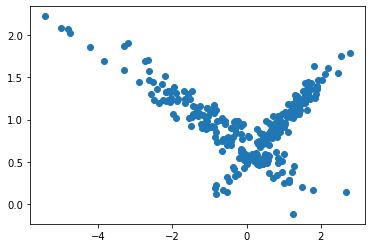

In [424]:
# %% 사이킷런 교차 데이터
df, y = datasets.make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, random_state=(1))
plt.scatter(df[:, 0], df[:, 1])

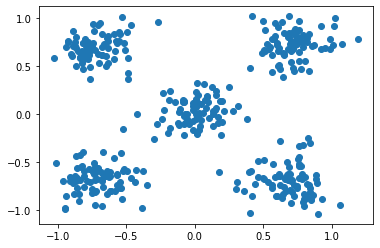

In [496]:
centers = [[0, 0], [0.7, 0.7], [-0.7, 0.7], [0.7, -0.7], [-0.7, -0.7]]
df, y = datasets.make_blobs(n_samples=400, n_features=2, centers=centers, cluster_std=0.15)
plt.scatter(df[:, 0], df[:, 1])

In [497]:
def random_centroid(df, n_cls):
    n_cols = df.shape[1]
    
    centroids = np.zeros([n_cls,n_cols])
    
    for k in range(n_cls):
        centroid = []
        for i in range(n_cols):          
            random = np.random.normal(df[:,i].mean(), df[:,i].std(),1)
            centroid.append(random[0])
        centroids[k] = centroid
        
    return centroids

In [531]:
start_centroid = random_centroid(df, 50)

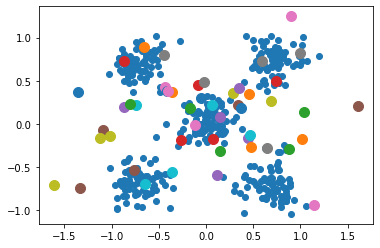

In [532]:
def visualize(df, centroid):
    plt.scatter(df[:, 0], df[:, 1])
    for k in range(len(centroid)):  # centroid 그리기
        plt.scatter(centroid[k][0], centroid[k][1], s=100)
        
visualize(df, start_centroid)

In [533]:
def point_to_centroid(centroids):
    distance = np.zeros([df.shape[0],len(centroids)])
    for i, centroid in enumerate(centroids):
        for j, xi in enumerate(df):
            dist = np.linalg.norm(xi-centroid)
            distance[j,i] = dist
    
    return distance

In [534]:
distance = point_to_centroid(start_centroid)
distance.shape

(400, 50)

In [535]:
def reduce_centroid(centroids, distance):
    belong_to = np.zeros([df.shape[0],len(centroids)])
    
    for j, dist in enumerate(distance):
        for i, d in enumerate(dist):
            if d < 0.5:
                belong_to[j,i] = 1
    del_idx = []            
    for k in range(len(centroids)):
        if Counter(belong_to[:,k])[0] > len(df)-5: ## 클러스터에 속한 포인트가 10개 이하면 삭제
            del_idx.append(k)
            
    new_centroids = np.delete(centroids, del_idx, axis = 0)
    
    return new_centroids

reduced_centroids = reduce_centroid(start_centroid, distance)

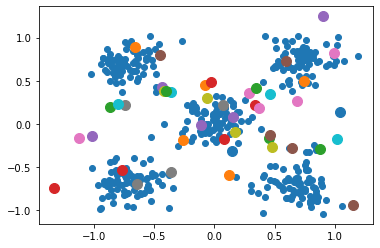

In [536]:
visualize(df, reduced_centroids)

In [537]:
def concat_centroid(centroids):
    del_idx = []
    i=0
    while i == len(centroids):
        tmp = []
        for j in range(len(centroids)):
            if i < j:
                c_dist = np.linalg.norm(centroids[i] - centroids[j])
                tmp.append(c_dist)
            else :
                tmp.append(100)
          
        while min(tmp) < 2:
            del_idx.append(np.argmin(tmp))
            tmp[np.argmin(tmp)] = 100 
        
        i+=1
        

    
    new_centroids = np.delete(centroids, del_idx, axis = 0)
          
    return new_centroids

In [538]:
def concat_centroid(centroids):
    del_idx = []
    for i in range(len(reduced_centroids)-1):
        tmp = []
        for j in range(len(centroids)):
            if i < j:
                c_dist = np.linalg.norm(centroids[i] - centroids[j])
                tmp.append(c_dist)
            else :
                tmp.append(100)
#         if min(tmp) < 0.5:
                del_idx.append(np.argmin(tmp))
    
    new_centroids = np.delete(centroids, del_idx, axis = 0)
          
    return new_centroids

In [539]:
new_centroids = concat_centroid(reduced_centroids)

while len(new_centroids) > 6:
    new_centroids = concat_centroid(new_centroids)
    
result = new_centroids

In [540]:
result

array([[ 0.11904373, -0.58534674],
       [-0.40180244,  0.37891478],
       [-0.02655483,  0.48946257],
       [-1.02066094, -0.13928327],
       [ 0.46079762, -0.12422478],
       [ 0.36796514,  0.18174986]])

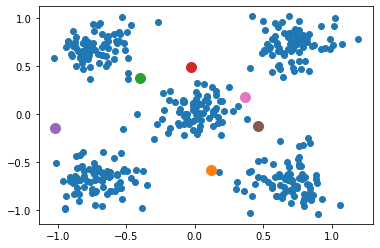

In [541]:
visualize(df, result)

In [542]:
def tagging(centroids):
    
    distances = point_to_centroid(centroids)
    labels = []
    for dist in distances:
        labels.append(np.argmin(dist))
        
    return labels

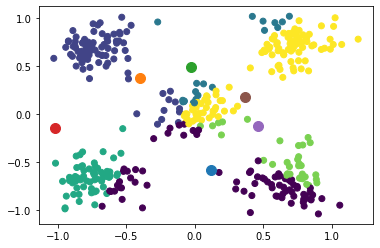

In [543]:
tag_ = tagging(result)

plt.scatter(df[:, 0], df[:, 1], c=tag_)
for k in range(len(result)):  # centroid 그리기
    plt.scatter(result[k][0], result[k][1], s=100)

In [544]:
def update_centroid(centroids, tag_):
    data = pd.DataFrame(df)
    data['tag'] = tag_
    data_2 = data.sort_values('tag')
    data_2 = data_2.reset_index()
    centroids_list = []
    for j in range(len(centroids)):
        asd = data_2[data_2['tag']==j]
        del asd['index']
        del asd['tag']

        summation = 0
        data = []
        for i in range(len(asd)):
            xi = [asd.iloc[i,0], asd.iloc[i,1]]
            data.append(xi)
            x_mu = xi-centroids[j]
            tmp = np.sqrt(np.square(x_mu[0]) + np.square(x_mu[1])) 
            summation += math.exp((tmp)/2*np.square(df.std()))
        weight = []
        for i in range(len(asd)):
            xi = [asd.iloc[i,0], asd.iloc[i,1]]
            x_mu = xi-centroids[j]
            tmp = np.sqrt(np.square(x_mu[0]) + np.square(x_mu[1]))
            weight.append(math.exp((tmp)/2*np.square(df.std())) / summation)

        centroids_list.append(sum(np.array(data) * np.array(weight)[:,None]))

    return centroids_list

updata_cent = update_centroid(result, tag_)

In [545]:
updata_cent

[array([ 0.29279638, -0.69727304]),
 array([-0.67010198,  0.61537416]),
 array([0.19135569, 0.51521306]),
 array([-0.76749506, -0.65764771]),
 array([ 0.66048186, -0.47698904]),
 array([0.50614766, 0.48515213])]

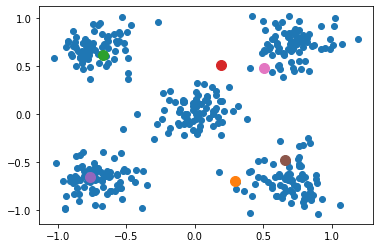

In [546]:
visualize(df, updata_cent)

In [547]:
re = concat_centroid(updata_cent)

In [548]:
re

array([[-0.67010198,  0.61537416],
       [ 0.19135569,  0.51521306],
       [-0.76749506, -0.65764771],
       [ 0.66048186, -0.47698904],
       [ 0.50614766,  0.48515213]])

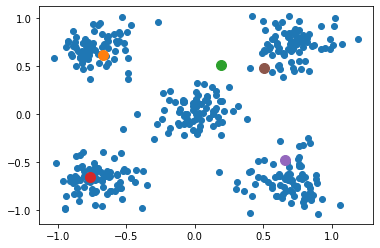

In [549]:
visualize(df, re)

In [550]:
up_tag = tagging(re)

In [551]:
updata_2 = update_centroid(re, up_tag)

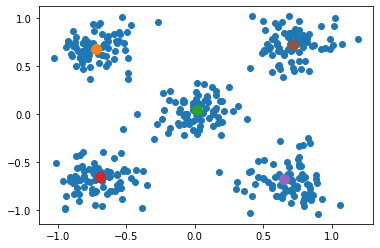

In [552]:
visualize(df, updata_2)

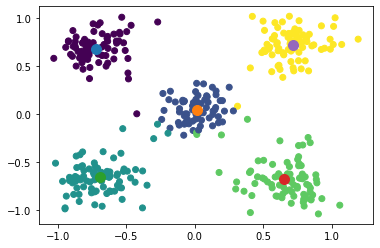

In [553]:
plt.scatter(df[:, 0], df[:, 1], c=up_tag)
for k in range(len(updata_2)):  # centroid 그리기
    plt.scatter(updata_2[k][0], updata_2[k][1], s=100)

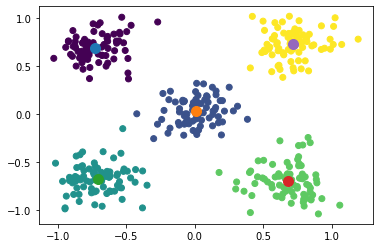

In [554]:
up_tag_2 = tagging(updata_2)
updata_3 = update_centroid(updata_2, up_tag_2)

plt.scatter(df[:, 0], df[:, 1], c=up_tag_2)
for k in range(len(updata_3)):  # centroid 그리기
    plt.scatter(updata_3[k][0], updata_3[k][1], s=100)